Install Packages/Libraries

In [18]:
%pip install --upgrade pip
%pip install torch torchvision torchaudio

# Transformers & datasets
%pip install pandas
%pip install datasets
%pip install peft
%pip install transformers
%pip install transformers[torch]
%pip install 'accelerate>=0.26.0'

# Plotting
%pip install matplotlib

# Evaluation
%pip install evaluate
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: transformers[torch]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import Packages/Libraries

In [ ]:
import os, math, torch,time, evaluate, pandas as pd, matplotlib.pyplot as plt, numpy as np
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType

Configurations

In [20]:
USE_LORA = False
DATA_DIR     = "outputs/bigcode-ts-output-50000-formatted"
METADATA_CSV = "outputs/bigcode-ts-output-50000-types.csv"
OUTPUT_DIR   = "outputs/typescriptmate-50000"
BATCH_SIZE   = 4
MAX_LENGTH   = 512
EPOCHS       = 3
LR           = 1e-5
GRAD_CLIP    = 0.0
SEED         = 42

Count number of TypeScipt files in folder

In [21]:
file_count = sum(len(files) for _, _, files in os.walk(DATA_DIR))
print("Total files:", file_count)

Total files: 46053


Check if MPS (Accelerated PyTorch Training for Apple Silicon) is supported

In [22]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


True
True


Load metadata for Type Awareness

In [23]:
df = pd.read_csv(METADATA_CSV)
for col in ["TypeAliases", "Interfaces"]:
    if col in df.columns:
        df[col] = df[col].fillna("")
print(f"Loaded {len(df)} metadata rows")

Loaded 46012 metadata rows


Attach file text

In [24]:
dataset_meta = Dataset.from_pandas(df, preserve_index=False)

def add_text(example):
    path = example["File"]
    if not os.path.isabs(path):
        path = os.path.join(DATA_DIR, path)
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            example["text"] = f.read()
    except:
        example["text"] = ""
    return example

dataset_meta = dataset_meta.map(add_text, batched=False)

Map: 100%|██████████| 46012/46012 [00:05<00:00, 9004.41 examples/s] 


Filter bad examples

In [25]:
dataset_meta = dataset_meta.filter(lambda ex: ex["text"].strip() != "")
print("Non-empty examples:", len(dataset_meta))

Filter: 100%|██████████| 46012/46012 [00:00<00:00, 106765.54 examples/s]

Non-empty examples: 46012


Split and filter train and validation data for annotated examples

In [26]:
splits = dataset_meta.train_test_split(test_size=0.1, seed=SEED)
datasets = DatasetDict({
    "train": splits["train"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"]),
    "validation": splits["test"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"])
})
print("Filtered split:")
print("  • train:", len(datasets["train"]))
print("  • validation:", len(datasets["validation"]))

Filter: 100%|██████████| 4602/4602 [00:00<00:00, 47706.96 examples/s]

Filtered split:
  • train: 6468
  • validation: 697


Tokenize

In [27]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

to_remove = df.columns.tolist() + ["text"]
tokenized = datasets.map(
    tokenize_fn,
    batched=True,
    remove_columns=to_remove
)

Map: 100%|██████████| 697/697 [00:07<00:00, 97.01 examples/s]


Sanity check on tokens

In [28]:
valid_count = sum(
    any(tok != tokenizer.eos_token_id for tok in ex["input_ids"])
    for ex in tokenized["train"]
)
print(f"Usable tokenized examples: {valid_count} / {len(tokenized['train'])}")

Usable tokenized examples: 6468 / 6468


Collator & base Model

In [29]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
base_model = AutoModelForCausalLM.from_pretrained("gpt2")

Apply LoRA if enabled

In [30]:
if USE_LORA:
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=4,
        lora_alpha=16,
        lora_dropout=0.0,
        target_modules=["c_attn"]  # you can inspect model to try others
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
else:
    model = base_model

Move model to supported device

In [31]:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

model.to(device)

Using device: mps


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

TrainingArguments

In [45]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    max_grad_norm=GRAD_CLIP,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    remove_unused_columns=False,
    push_to_hub=True,
    do_eval=True,
    metric_for_best_model="eval_loss",
    
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Trainer with loss logger

In [33]:
class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print("LOGS:", logs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    callbacks=[LossLogger()]
)

Training

In [34]:
trainer.train()

/Users/zfir/miniforge3/envs/dissertation_mps/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.394200
200,2.194900
300,2.124200
400,2.005200
500,1.974900
600,1.960800
700,1.894600
800,1.915400
900,1.851700
1000,1.843600


LOGS: {'loss': 2.3942, 'learning_rate': 9.795918367346939e-06, 'epoch': 0.06184291898577613}
LOGS: {'loss': 2.1949, 'learning_rate': 9.589775304061019e-06, 'epoch': 0.12368583797155226}
LOGS: {'loss': 2.1242, 'learning_rate': 9.383632240775099e-06, 'epoch': 0.18552875695732837}
LOGS: {'loss': 2.0052, 'learning_rate': 9.177489177489179e-06, 'epoch': 0.24737167594310452}
LOGS: {'loss': 1.9749, 'learning_rate': 8.971346114203258e-06, 'epoch': 0.30921459492888065}
LOGS: {'loss': 1.9608, 'learning_rate': 8.765203050917338e-06, 'epoch': 0.37105751391465674}
LOGS: {'loss': 1.8946, 'learning_rate': 8.559059987631418e-06, 'epoch': 0.4329004329004329}
LOGS: {'loss': 1.9154, 'learning_rate': 8.352916924345496e-06, 'epoch': 0.49474335188620905}
LOGS: {'loss': 1.8517, 'learning_rate': 8.146773861059577e-06, 'epoch': 0.5565862708719852}
LOGS: {'loss': 1.8436, 'learning_rate': 7.940630797773655e-06, 'epoch': 0.6184291898577613}
LOGS: {'loss': 1.8633, 'learning_rate': 7.734487734487735e-06, 'epoch': 0

/Users/zfir/miniforge3/envs/dissertation_mps/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.7447, 'learning_rate': 6.497629354772213e-06, 'epoch': 1.051329622758194}
LOGS: {'loss': 1.783, 'learning_rate': 6.291486291486292e-06, 'epoch': 1.1131725417439704}
LOGS: {'loss': 1.7488, 'learning_rate': 6.085343228200371e-06, 'epoch': 1.1750154607297465}
LOGS: {'loss': 1.7251, 'learning_rate': 5.879200164914451e-06, 'epoch': 1.2368583797155226}
LOGS: {'loss': 1.7767, 'learning_rate': 5.673057101628531e-06, 'epoch': 1.2987012987012987}
LOGS: {'loss': 1.7473, 'learning_rate': 5.46691403834261e-06, 'epoch': 1.3605442176870748}
LOGS: {'loss': 1.7654, 'learning_rate': 5.260770975056689e-06, 'epoch': 1.4223871366728509}
LOGS: {'loss': 1.7566, 'learning_rate': 5.0546279117707695e-06, 'epoch': 1.4842300556586272}
LOGS: {'loss': 1.7262, 'learning_rate': 4.848484848484849e-06, 'epoch': 1.546072974644403}
LOGS: {'loss': 1.7979, 'learning_rate': 4.642341785198928e-06, 'epoch': 1.6079158936301794}
LOGS: {'loss': 1.707, 'learning_rate': 4.436198721913008e-06, 'epoch': 1.6697588126

/Users/zfir/miniforge3/envs/dissertation_mps/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'loss': 1.7352, 'learning_rate': 3.1993403421974858e-06, 'epoch': 2.0408163265306123}
LOGS: {'loss': 1.7252, 'learning_rate': 2.993197278911565e-06, 'epoch': 2.102659245516388}
LOGS: {'loss': 1.6801, 'learning_rate': 2.787054215625644e-06, 'epoch': 2.1645021645021645}
LOGS: {'loss': 1.7434, 'learning_rate': 2.580911152339724e-06, 'epoch': 2.226345083487941}
LOGS: {'loss': 1.6614, 'learning_rate': 2.3747680890538034e-06, 'epoch': 2.2881880024737167}
LOGS: {'loss': 1.6776, 'learning_rate': 2.168625025767883e-06, 'epoch': 2.350030921459493}
LOGS: {'loss': 1.6732, 'learning_rate': 1.962481962481963e-06, 'epoch': 2.411873840445269}
LOGS: {'loss': 1.6777, 'learning_rate': 1.7563388991960424e-06, 'epoch': 2.473716759431045}
LOGS: {'loss': 1.7008, 'learning_rate': 1.550195835910122e-06, 'epoch': 2.5355596784168215}
LOGS: {'loss': 1.6767, 'learning_rate': 1.3440527726242014e-06, 'epoch': 2.5974025974025974}
LOGS: {'loss': 1.6967, 'learning_rate': 1.137909709338281e-06, 'epoch': 2.6592455

TrainOutput(global_step=4851, training_loss=1.7947106849923622, metrics={'train_runtime': 4196.4964, 'train_samples_per_second': 4.624, 'train_steps_per_second': 1.156, 'total_flos': 5070110588928000.0, 'train_loss': 1.7947106849923622, 'epoch': 3.0})

Save model, tokenizer and deploy

In [35]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
trainer.save_model(OUTPUT_DIR)

Basic evaluation

In [36]:
eval_results = trainer.evaluate()

print("Full eval results:", eval_results)

if eval_results.get("eval_loss") is not None and not math.isnan(eval_results["eval_loss"]):
    print("Validation Perplexity: ", math.exp(eval_results["eval_loss"]))
else:
    print("NaN eval loss")

/Users/zfir/miniforge3/envs/dissertation_mps/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


LOGS: {'eval_loss': 1.6268829107284546, 'eval_runtime': 44.737, 'eval_samples_per_second': 15.58, 'eval_steps_per_second': 3.912, 'epoch': 3.0}
Full eval results: {'eval_loss': 1.6268829107284546, 'eval_runtime': 44.737, 'eval_samples_per_second': 15.58, 'eval_steps_per_second': 3.912, 'epoch': 3.0}
Validation Perplexity:  5.087990254915276


Convert the trainer log history into a DataFrame

In [37]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
print(df)

      loss  learning_rate     epoch  step  train_runtime  \
0   2.3942   9.795918e-06  0.061843   100            NaN   
1   2.1949   9.589775e-06  0.123686   200            NaN   
2   2.1242   9.383632e-06  0.185529   300            NaN   
3   2.0052   9.177489e-06  0.247372   400            NaN   
4   1.9749   8.971346e-06  0.309215   500            NaN   
5   1.9608   8.765203e-06  0.371058   600            NaN   
6   1.8946   8.559060e-06  0.432900   700            NaN   
7   1.9154   8.352917e-06  0.494743   800            NaN   
8   1.8517   8.146774e-06  0.556586   900            NaN   
9   1.8436   7.940631e-06  0.618429  1000            NaN   
10  1.8633   7.734488e-06  0.680272  1100            NaN   
11  1.8663   7.528345e-06  0.742115  1200            NaN   
12  1.8840   7.322202e-06  0.803958  1300            NaN   
13  1.8645   7.116059e-06  0.865801  1400            NaN   
14  1.8213   6.909915e-06  0.927644  1500            NaN   
15  1.8088   6.703772e-06  0.989487  160

Plot training loss vs global step

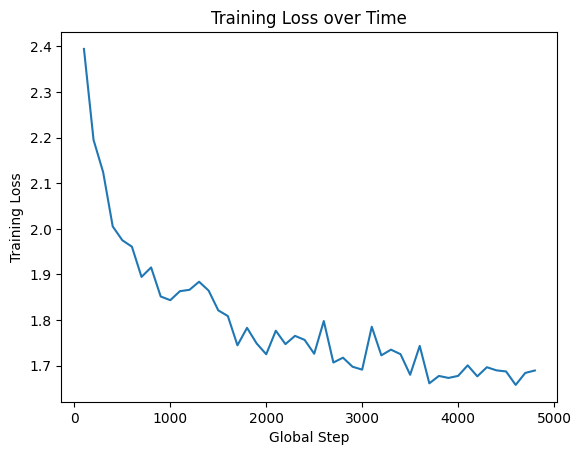

In [38]:
train_df = df[df["loss"].notna()]
plt.plot(train_df["step"], train_df["loss"])
plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time")
plt.show()

Plot training perplexity vs global step

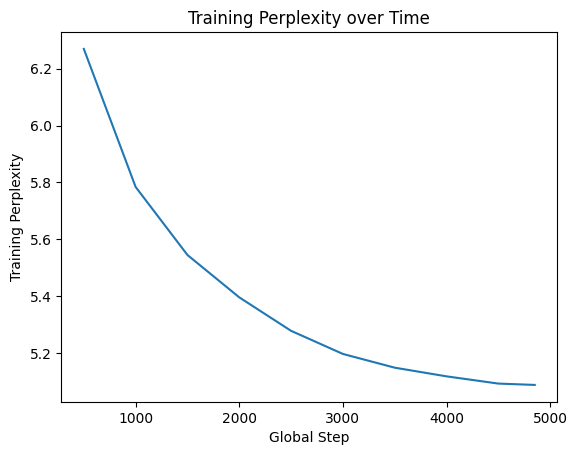

In [55]:
train_df = df[df["perplexity"].notna()]
plt.plot(train_df["step"], train_df["perplexity"])
plt.xlabel("Global Step")
plt.ylabel("Training Perplexity")
plt.title("Training Perplexity over Time")
plt.show()

Load each checkpoint’s weights into your model

In [50]:
ckpts = [
    "checkpoint-500","checkpoint-1000","checkpoint-1500",
    "checkpoint-2000","checkpoint-2500","checkpoint-3000",
    "checkpoint-3500","checkpoint-4000","checkpoint-4500",
    "checkpoint-4851"
]

records = []
for ckpt in ckpts:
    ckpt_path = f"{OUTPUT_DIR}/{ckpt}"

    # 1) Reload the model weights
    model = AutoModelForCausalLM.from_pretrained(ckpt_path)
    model.to(trainer.args.device)

    # 2) Patch the Trainer’s model
    trainer.model = model

    # 3) Run evaluation on your validation split
    metrics = trainer.evaluate()        # no args here

    # 4) Record step & loss (& perplexity)
    step = int(ckpt.split("-")[-1])
    loss = metrics["eval_loss"]
    records.append({
      "step": step,
      "eval_loss": loss,
      "perplexity": math.exp(loss)
    })

df = pd.DataFrame(records).sort_values("step")

LOGS: {'eval_loss': 1.83572518825531, 'eval_runtime': 85.0951, 'eval_samples_per_second': 8.191, 'eval_steps_per_second': 2.057, 'epoch': 3.0}
LOGS: {'eval_loss': 1.7551329135894775, 'eval_runtime': 68.5962, 'eval_samples_per_second': 10.161, 'eval_steps_per_second': 2.551, 'epoch': 3.0}
LOGS: {'eval_loss': 1.7128853797912598, 'eval_runtime': 61.5685, 'eval_samples_per_second': 11.321, 'eval_steps_per_second': 2.842, 'epoch': 3.0}
LOGS: {'eval_loss': 1.685648798942566, 'eval_runtime': 60.7153, 'eval_samples_per_second': 11.48, 'eval_steps_per_second': 2.882, 'epoch': 3.0}
LOGS: {'eval_loss': 1.6635816097259521, 'eval_runtime': 75.7203, 'eval_samples_per_second': 9.205, 'eval_steps_per_second': 2.311, 'epoch': 3.0}
LOGS: {'eval_loss': 1.6480712890625, 'eval_runtime': 51.712, 'eval_samples_per_second': 13.479, 'eval_steps_per_second': 3.384, 'epoch': 3.0}
LOGS: {'eval_loss': 1.6387287378311157, 'eval_runtime': 63.669, 'eval_samples_per_second': 10.947, 'eval_steps_per_second': 2.749, 'ep

Plot evaluation loss vs global step

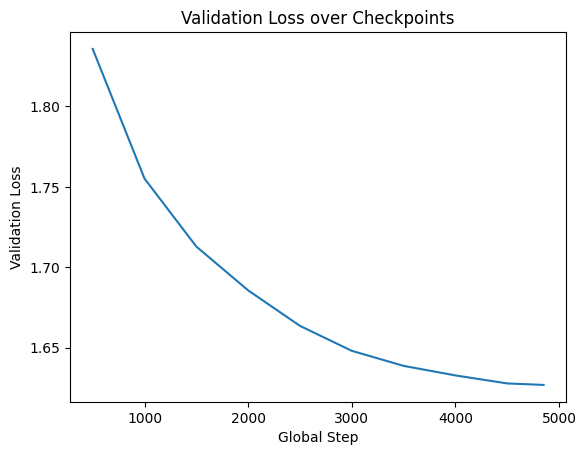

In [56]:
plt.figure()
plt.plot(df["step"], df["eval_loss"])
plt.xlabel("Global Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Checkpoints")
plt.show()

Convert loss to perplexity for easier interpretation: perplexity = exp(loss)

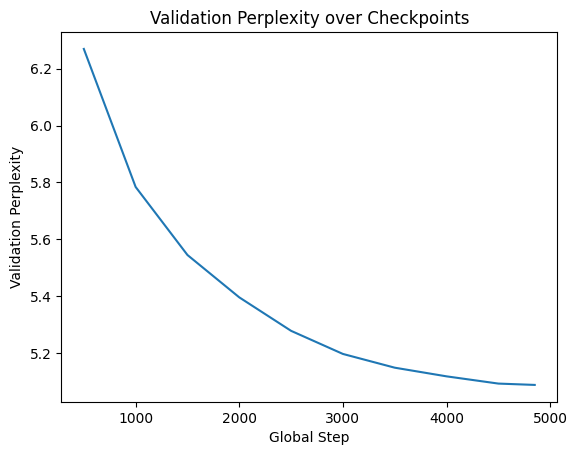

In [57]:
plt.figure()
plt.plot(df["step"], df["perplexity"])
plt.xlabel("Global Step")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity over Checkpoints")
plt.show()

Top-5 Token Accuracy and MRR over validation set

In [ ]:
def stream_topk_mrr(model, trainer, k=5, batch_size=1):
    """
    Streams through the Trainer’s eval_dataloader batch-by-batch,
    accumulates top-k matches and reciprocal ranks,
    and keeps memory use small.
    """
    # Put model in eval mode & grab device
    model.eval()
    device = next(model.parameters()).device
    
    # Use the Trainer’s built-in eval dataloader (with correct collation)
    loader: DataLoader = trainer.get_eval_dataloader()
    
    total_tokens = 0
    topk_matches = 0
    rr_sum = 0.0

    with torch.no_grad():
        for batch in loader:
            # batch is a dict of torch.Tensor already
            labels = batch.pop("labels").to(device)   # shape (bs, seq_len)
            # move all other inputs to device
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # forward
            logits = model(**inputs).logits.cpu().numpy()  # (bs, seq_len, vocab_size)
            lbls   = labels.cpu().numpy()                 # (bs, seq_len)

            # mask out padding tokens
            mask = lbls != -100                             # (bs, seq_len)
            flat_logits = logits[mask].reshape(-1, logits.shape[-1])  # (N_toks, V)
            flat_labels = lbls[mask].reshape(-1)                     # (N_toks,)

            # Top-k matches via argpartition (cheap per-row)
            topk_idxs = np.argpartition(flat_logits, -k, axis=-1)[:, -k:]
            topk_matches += np.sum([flat_labels[i] in topk_idxs[i]
                                    for i in range(flat_labels.shape[0])])

            # MRR: rank = 1 + # of logits > true_logit
            true_scores = flat_logits[np.arange(flat_labels.shape[0]), flat_labels]
            ranks = 1 + np.sum(flat_logits > true_scores[:, None], axis=1)
            rr_sum += np.sum(1.0 / ranks)

            total_tokens += flat_labels.shape[0]

    topk_acc = topk_matches / total_tokens
    mrr      = rr_sum / total_tokens
    return topk_acc, mrr

# Usage:
top5_acc, mrr = stream_topk_mrr(model, trainer, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"MRR:             {mrr:.4f}")


/Users/zfir/miniforge3/envs/dissertation_mps/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Top-5 Accuracy: 0.1899
MRR:             0.1572


Top-5 Accuracy bar chart

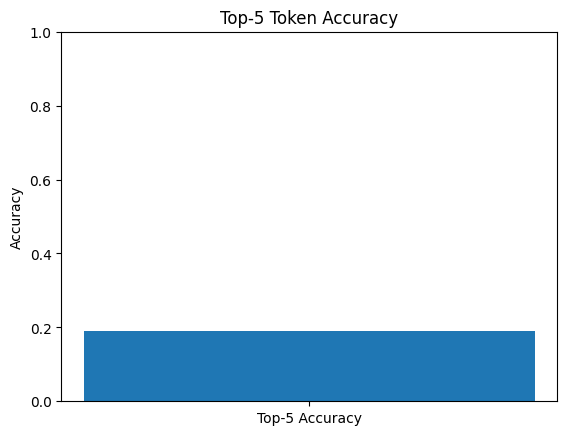

In [42]:
plt.figure()
plt.bar(['Top-5 Accuracy'], [top5_acc])
plt.ylim(0, 1)
plt.title('Top-5 Token Accuracy')
plt.ylabel('Accuracy')
plt.show()

MRR bar chart

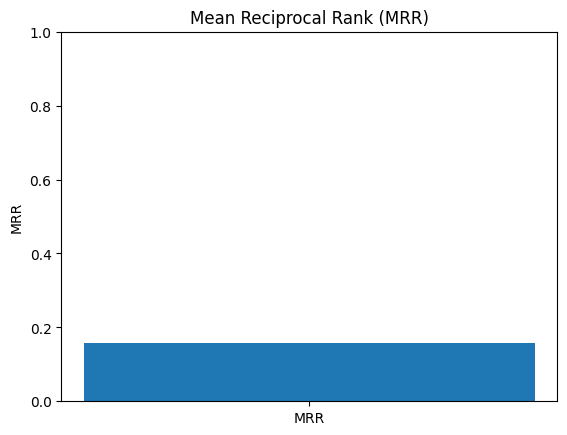

In [43]:
plt.figure()
plt.bar(['MRR'], [mrr])
plt.ylim(0, 1)
plt.title('Mean Reciprocal Rank (MRR)')
plt.ylabel('MRR')
plt.show()

Inference Latency Histogram
Measure per-sample inference latency and visualize

Mean latency: 0.0163s
Std  latency: 0.0027s


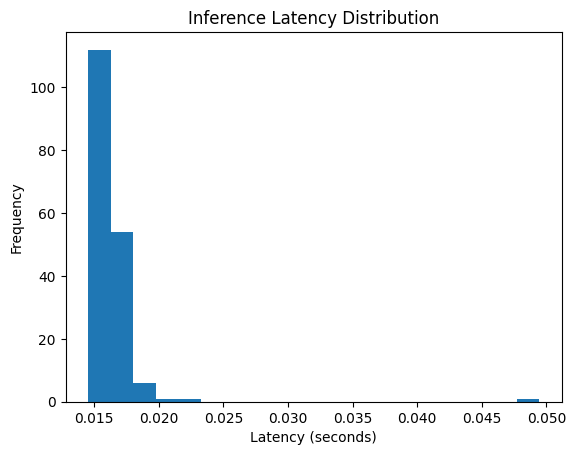

In [44]:
model.eval()
device = next(model.parameters()).device
loader = trainer.get_eval_dataloader()

latencies = []
with torch.no_grad():
    for batch in loader:
        batch.pop("labels", None)
        inputs = {k: v.to(device) for k, v in batch.items()}
        start = time.monotonic()
        _ = model(**inputs)
        end = time.monotonic()
        latencies.append(end - start)

latencies = np.array(latencies)

print(f"Mean latency: {latencies.mean():.4f}s")
print(f"Std  latency: {latencies.std():.4f}s")

plt.figure()
plt.hist(latencies, bins=20)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Inference Latency Distribution")
plt.show()
